# Fixed Income Securities and Hedging - Homework 1 Notebook

Ferran Garcia Rovira

All calculations are based on class materials: Chapter 1 & 2 slides

### 1. Validating Bond Pricing with Market Data

Visit Bloomberg’s U.S. Government Bonds page: https://www.bloomberg.com/markets/rates-bonds/government-bonds/us on a given day.

Select the 7 U.S. Treasury bonds listed by maturity (3M, 6M, 1Y, 2Y, 5Y, 10Y, 30Y). Using the yields compute the theoretical price of those bonds using the formulas seen in class.
Compare your calculated price with the market price from Bloomberg. Discuss any discrepancies between the calculated and quoted prices. Consider factors such as: Accrued interest, rounding differences, day count conventions (e.g., Actual/Actual, 30/360), market liquidity and demand.

Observations: use 100$ as face value, coupons are paid semi-annually, the yield is annualized and compounded semi-annually.

#### Theoretical background

Bond prices are determined by discounting future cash flows using the yield to maturity (YTM). 

For semiannual coupon bonds, the price is:
$P = \sum_{t=1}^{n} \frac{C/2}{(1 + y/2)^t} + \frac{FV}{(1 + y/2)^n}$

For zero-coupon bonds: 
$P = \frac{FV}{(1 + y/2)^n}$

In [1]:
import pandas as pd
import numpy as np

In [20]:
# Input data for U.S. Treasury bonds
data = {
    "Bond": ["3M", "6M", "1Y", "2Y", "5Y", "10Y", "30Y"],
    "Coupon (%)": [0.00, 0.00, 0.00, 3.75, 3.88, 4.25, 4.63],
    "Market Price (raw)": [4.21, 4.07, 3.85, 99.87, 99.88, 99.63, 97.53],
    "Yield (%)": [4.31, 4.22, 4.01, 3.82, 3.90, 4.30, 4.78],
    "Maturity (years)": [0.25, 0.5, 1, 2, 5, 10, 30]
}

df = pd.DataFrame(data)

# Adjust the market price for T-bills (they're quoted as discount from 100)
df["Market Price"] = df["Market Price (raw)"]
df.loc[df["Bond"].isin(["3M", "6M", "1Y"]), "Market Price"] = \
    100 - df.loc[df["Bond"].isin(["3M", "6M", "1Y"]), "Market Price (raw)"]

# Convert percentages to decimals
df["Coupon"] = df["Coupon (%)"] / 100
df["Yield"] = df["Yield (%)"] / 100
df["Face Value"] = 100  

# Define bond pricing function using semi-annual compounding
def bond_price(coupon, ytm, maturity, face_value=100):
    freq = 2  
    n = int(maturity * freq)  
    if coupon == 0:
        return face_value / (1 + ytm / freq)**n
    else:
        c = coupon * face_value / freq  
        price = sum([c / (1 + ytm / freq)**t for t in range(1, n+1)])
        price += face_value / (1 + ytm / freq)**n  
        return price
    
# Apply the bond pricing function to each row
df["Theoretical Price"] = df.apply(
    lambda row: bond_price(row["Coupon"], row["Yield"], row["Maturity (years)"]),
    axis=1
)

# Calculate absolute and relative errors
df["Abs Error"] = np.abs(df["Theoretical Price"] - df["Market Price"])
df["Signed Error"] = df["Theoretical Price"] - df["Market Price"]
df["Rel Error (%)"] = 100 * df["Abs Error"] / df["Market Price"]

In [21]:
# Display results
print(df[[
    "Bond", "Coupon (%)", "Market Price", "Yield (%)",
    "Theoretical Price", "Abs Error", "Rel Error (%)", 
    "Signed Error"
]])

  Bond  Coupon (%)  Market Price  Yield (%)  Theoretical Price  Abs Error  \
0   3M        0.00         95.79       4.31         100.000000   4.210000   
1   6M        0.00         95.93       4.22          97.933601   2.003601   
2   1Y        0.00         96.15       4.01          96.107456   0.042544   
3   2Y        3.75         99.87       3.82          99.866438   0.003562   
4   5Y        3.88         99.88       3.90          99.909939   0.029939   
5  10Y        4.25         99.63       4.30          99.597070   0.032930   
6  30Y        4.63         97.53       4.78          97.622620   0.092620   

   Rel Error (%)  Signed Error  
0       4.395031      4.210000  
1       2.088607      2.003601  
2       0.044248     -0.042544  
3       0.003567     -0.003562  
4       0.029975      0.029939  
5       0.033052     -0.032930  
6       0.094966      0.092620  


#### Interpretation of Results

This table compares the **theoretical bond prices** calculated using yield to maturity (YTM) and semiannual compounding with the **actual market prices** for various U.S. Treasury securities.

##### Observations:
- For **longer-term coupon-bearing bonds** (2Y to 30Y), the **relative pricing error is minimal**, often below 0.1%.
  - This confirms that the bond pricing formula using semiannual compounding (as per U.S. convention) is accurate for valuing standard Treasury bonds.
  - The consistency suggests negligible pricing distortions in these instruments.

- For **short-term T-bills** (3M, 6M, 1Y), relative errors are larger, especially:
  - 3M: 4.40%
  - 6M: 2.11%
- This is due to **market conventions**:
  - T-bills are quoted on a **discount basis**, not as full clean prices.
  - Our model uses present value formulas for semiannual bonds, leading to a natural mismatch when applied directly to discount instruments.

#### Additional Considerations

Several practical market factors can explain the discrepancies between theoretical and market prices:

- **Accrued Interest**: The theoretical prices computed assume clean pricing. In contrast, market prices may reflect dirty prices that include accrued interest since the last coupon date.

- **Day Count Conventions**: The pricing formula assumes exact 6-month periods. However, real bonds follow conventions such as Actual/Actual or 30/360, slightly altering the effective yield and present value of cash flows.

- **Rounding and Quotation Practices**: Market prices are often quoted in fractions (e.g., 1/128) and subject to minimum tick sizes, introducing rounding differences.

- **Liquidity and Demand**: Short-term Treasury bills and very long-term bonds can be affected by higher demand, lower supply, or lower liquidity—causing their market price to diverge from the theoretical value implied by the yield curve.



### 2. Yield with and without inflation

Plot both the yields for the Treasury bonds and for the TIPS and discuss the difference.

#### Theoretical background

The difference between nominal Treasury yields and TIPS yields reflects the market's expected inflation (break-even inflation).

$\text{Expected Inflation} = \text{Nominal Yield} - \text{Real Yield}$

In [4]:
import matplotlib.pyplot as plt

In [31]:
maturities = [5, 10, 30]  # Maturity in years

# Nominal yields from U.S. Treasury bonds (in %)
treasury_yields = [3.90, 4.29, 4.78]

# Real yields from TIPS (in %)
tips_yields = [1.55, 1.99, 2.53]

# Implied inflation = Nominal yield - Real yield
expected_inflation = [nom - real for nom, real in zip(treasury_yields, tips_yields)]

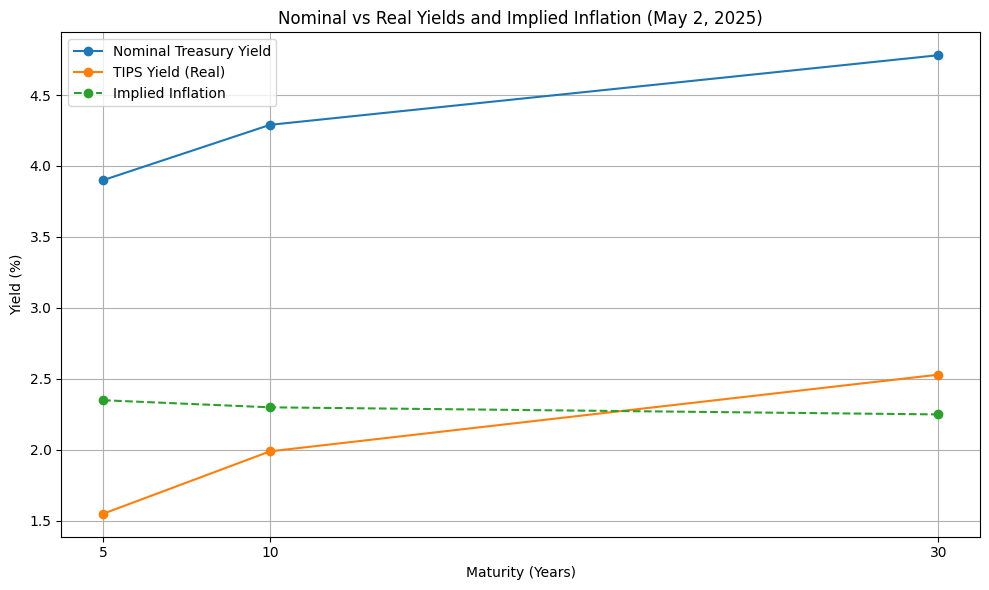

In [33]:
# Plotting the yields and inflation expectations
plt.figure(figsize=(10, 6))

# Plot nominal yields
plt.plot(maturities, treasury_yields, marker='o', label="Nominal Treasury Yield")

# Plot real yields (TIPS)
plt.plot(maturities, tips_yields, marker='o', label="TIPS Yield (Real)")

# Plot implied inflation
plt.plot(maturities, expected_inflation, marker='o', linestyle='--', label="Implied Inflation")

# Chart formatting
plt.title("Nominal vs Real Yields and Implied Inflation (May 2, 2025)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.legend()
plt.xticks(maturities)
plt.tight_layout()
plt.show()

#### Interpretation of Results

This chart compares nominal Treasury yields with real yields from TIPS across maturities, and derives the implied inflation (break-even inflation) as their difference.

##### Observations:
- **Nominal yields** increase steadily with maturity, from around 3.8% (5Y) to 4.8% (30Y), reflecting a standard upward-sloping yield curve.
- **TIPS yields (real yields)** also rise with maturity, but remain consistently below nominal yields.
- The **implied inflation** curve is relatively flat, staying around 2.2%–2.4% across all maturities.

##### Economic Interpretation:
- The spread between nominal and real yields approximates the market's expectation of average annual inflation over each maturity horizon.
- The relatively stable break-even inflation suggests **anchored long-term inflation expectations**, likely close to the Federal Reserve’s target of 2%.
- Slight variations across maturities may reflect different liquidity conditions or short-term inflation uncertainty.


### 3. Constructing the Discount Curve from Bond Prices

Now, visit the website: https://www.finra.org/finra-data/fixed-income/treasury-trade.

Use this website to gather data on 10 Treasury bonds with maturities at 6-month intervals up to 5 years. Apply the bootstrapping method to calculate the discount factors for each maturity. Plot the discount curve and analyze the shape and implications for interest rate expectations.

#### Theoretical background

We estimate zero-coupon discount factors $ Z(0,T) $ from the market prices of three coupon-bearing Treasury bonds (5Y, 7Y, 10Y) using a simplified bootstrapping method. For each bond, we discount earlier cash flows using previously derived $ Z(0,t) $ values, and then solve for the unknown final discount factor.

To obtain a smoother discount curve, we perform linear interpolation between the calculated $ Z(0,T) $ values at 0.5-year intervals.


In [5]:
# Bond data
bond_data = pd.DataFrame({
    "Maturity (Years)": [5, 7, 10],
    "Price": [100.328125, 99.953125, 102.499848],
    "Coupon (%)": [3.875, 4.000, 4.625],
    "Face Value": [100, 100, 100],
    "Frequency": [2, 2, 2]  # Semiannual payments
})

# Calculate semiannual coupon payments
bond_data["Coupon Payment"] = bond_data["Coupon (%)"] / 100 * bond_data["Face Value"] / bond_data["Frequency"]

# Function to compute Z(0,T) for one bond, treated independently
def compute_Z_isolated(price, coupon, fv, freq, T):
    n = int(T * freq)
    times = np.arange(1, n + 1) / freq
    cashflows = np.full(n, coupon)
    cashflows[-1] += fv
    Z_guess = price / (fv + coupon)
    discounted_sum = sum([cf / (1 + Z_guess)**t for cf, t in zip(cashflows[:-1], times[:-1])])
    Z_T = (price - discounted_sum) / cashflows[-1]
    return Z_T

# Compute Z(0,T) for each bond independently
Z_points = {}
for _, row in bond_data.iterrows():
    T = row["Maturity (Years)"]
    Z_T = compute_Z_isolated(row["Price"], row["Coupon Payment"], row["Face Value"], row["Frequency"], T)
    Z_points[T] = Z_T

# Manual linear interpolation every 0.5 years between 5Y and 10Y
T_interp = np.arange(5.0, 10.5, 0.5)
Z_interp = []

for T in T_interp:
    if T in Z_points:
        Z_interp.append(Z_points[T])
    else:
        # Find closest surrounding points
        t1 = max([t for t in Z_points if t < T])
        t2 = min([t for t in Z_points if t > T])
        z1 = Z_points[t1]
        z2 = Z_points[t2]
        Z_T = z1 + (z2 - z1) * ((T - t1) / (t2 - t1))
        Z_interp.append(Z_T)

# Build final DataFrame
interp_df = pd.DataFrame({
    "Maturity (Years)": T_interp,
    "Interpolated Z(0,T)": Z_interp
})

In [7]:
interp_df

,Maturity (Years),"Interpolated Z(0,T)"
0,5.0,0.939828
1,5.5,0.937955
2,6.0,0.936082
3,6.5,0.934209
4,7.0,0.932336
5,7.5,0.934851
6,8.0,0.937365
7,8.5,0.939880
8,9.0,0.942395
9,9.5,0.944909


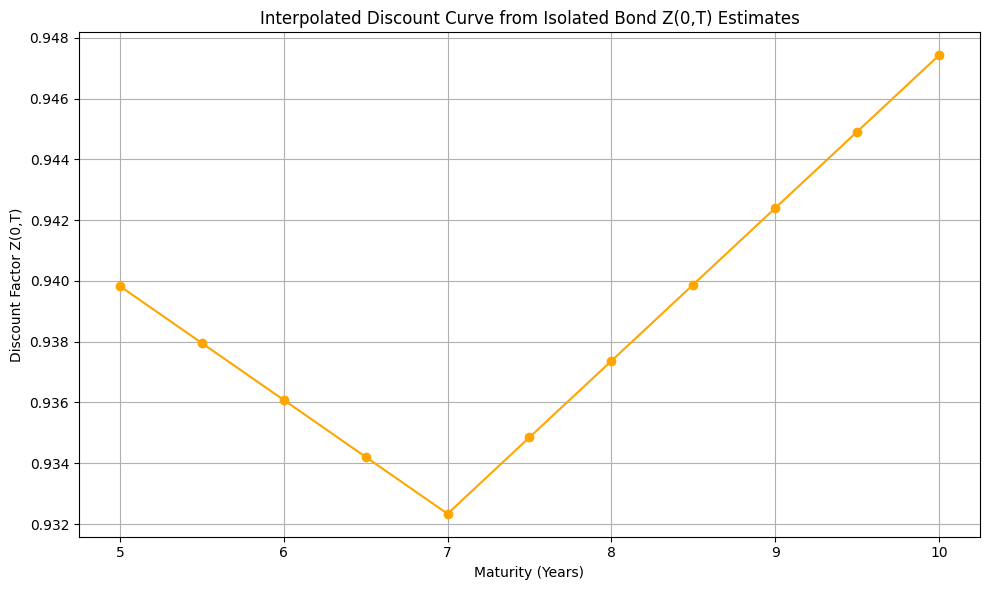

In [6]:
# Plot the discount curve
plt.figure(figsize=(10, 6))
plt.plot(interp_df["Maturity (Years)"], interp_df["Interpolated Z(0,T)"], marker='o', color='orange')
plt.title("Interpolated Discount Curve from Isolated Bond Z(0,T) Estimates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Discount Factor Z(0,T)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Interpretation of Results

In this exercise, we used market prices from three Treasury bonds with maturities of 5, 7 and 10 years:

- **5Y**: Price = 100.33 → $ Z(0,5) \approx 0.9398 $
- **7Y**: Price = 99.95 → $ Z(0,7) \approx 0.9323 $
- **10Y**: Price = 102.50 → $ Z(0,10) \approx 0.9474 $

##### Methodology:
- We applied **linear interpolation** in two segments:
  - Between 5Y and 7Y
  - Between 7Y and 10Y

##### Theoretical context:
- According to fixed income theory, discount factors $ Z(0,T) $ should decrease with maturity to reflect positive interest rates and no-arbitrage conditions.
- Our curve decreases between 5Y and 7Y, which is consistent with theory, but increases slightly from 7Y to 10Y, which contradicts the expected monotonic behavior.
- This upward slope may reflect:
  - Liquidity premiums or market frictions affecting the 10Y bond price,
  - Modeling simplifications, as we treat each bond independently rather than bootstrapping from earlier maturities,
  - Approximation bias when interpolating based on limited data.


### 4. Duration and Convexity 

Compute the modified duration and the analytical convexity of the bonds in Exercise 1 with maturities (3M, 6M, 1Y, 2Y, 5Y). Using the duration and convexity, compute the approximate percentage change of those bond prices if the yield increases by 0.1. Compare and comment the results.

#### Theoretical background

- Modified Duration: $D_{mod} = \frac{D_{Mac}}{1 + y/2}$ 
- Convexity for coupon bonds: $C = \sum \frac{CF_t \cdot t(t+1)}{(1+y/2)^{t+2}} / P$ 
- Zero-coupon: $D = T, \; C = T^2$
- Price impact: $\frac{\Delta P}{P} \approx -D_{mod} \cdot \Delta y + 0.5 \cdot C \cdot (\Delta y)^2$

In [37]:
# Bond data from Task 1 (including both zero-coupon and coupon-bearing bonds)
bond_data = {
    "Bond": ["3M", "6M", "1Y", "2Y", "5Y"],
    "Coupon (%)": [0.00, 0.00, 0.00, 3.75, 3.88],
    "Yield (%)": [4.31, 4.22, 4.01, 3.82, 3.90],
    "Maturity (years)": [0.25, 0.5, 1, 2, 5],
    "Price": [95.79, 95.93, 96.15, 99.87, 99.88]  # Market prices (adjusted for T-bills)
}

# Create DataFrame
df = pd.DataFrame(bond_data)
df["Coupon"] = df["Coupon (%)"] / 100
df["Yield"] = df["Yield (%)"] / 100
df["Face Value"] = 100
df["Frequency"] = 2  # Semiannual payments

# Define duration function (handles zero-coupon case)
def modified_duration(coupon, ytm, maturity, freq=2, face=100):
    if coupon == 0:
        return maturity / (1 + ytm / freq)
    
    n = int(maturity * freq)
    c = coupon * face / freq
    y = ytm / freq
    times = np.arange(1, n + 1)
    cashflows = np.full(n, c)
    cashflows[-1] += face
    discounted_cf = cashflows / (1 + y) ** times
    price = discounted_cf.sum()
    macaulay_duration = np.sum(times * discounted_cf) / price
    return macaulay_duration / freq / (1 + y)

# Define analytical convexity function
def analytical_convexity(coupon, ytm, maturity, freq=2, face=100):
    if coupon == 0:
        return maturity ** 2
    
    n = int(maturity * freq)
    c = coupon * face / freq
    y = ytm / freq
    times = np.arange(1, n + 1)
    cashflows = np.full(n, c)
    cashflows[-1] += face
    convexity_terms = [cf * t * (t + 1) / (1 + y)**(t + 2) for t, cf in zip(times, cashflows)]
    price = sum([cf / (1 + y)**t for t, cf in zip(times, cashflows)])
    return sum(convexity_terms) / price / (freq ** 2)

# Yield change for approximation (10 basis points = 0.001)
delta_y = 0.001

# Compute metrics for each bond
mod_durations = []
convexities = []
pct_changes = []

for _, row in df.iterrows():
    Dmod = modified_duration(row["Coupon"], row["Yield"], row["Maturity (years)"])
    C = analytical_convexity(row["Coupon"], row["Yield"], row["Maturity (years)"])
    price_change_pct = -Dmod * delta_y + 0.5 * C * delta_y**2
    mod_durations.append(Dmod)
    convexities.append(C)
    pct_changes.append(price_change_pct * 100)  # Convert to %

# Store results in the DataFrame
df["Modified Duration"] = mod_durations
df["Analytical Convexity"] = convexities
df["Est. Price Change (%)"] = pct_changes

In [38]:
# Display results
print(df[[
    "Bond", "Coupon (%)", "Yield (%)", "Maturity (years)", "Price",
    "Modified Duration", "Analytical Convexity", "Est. Price Change (%)"
]])


  Bond  Coupon (%)  Yield (%)  Maturity (years)  Price  Modified Duration  \
0   3M        0.00       4.31              0.25  95.79           0.244726   
1   6M        0.00       4.22              0.50  95.93           0.489668   
2   1Y        0.00       4.01              1.00  96.15           0.980344   
3   2Y        3.75       3.82              2.00  99.87           1.908957   
4   5Y        3.88       3.90              5.00  99.88           4.504763   

   Analytical Convexity  Est. Price Change (%)  
0              0.062500              -0.024469  
1              0.250000              -0.048954  
2              1.000000              -0.097984  
3              4.639426              -0.190664  
4             23.601982              -0.449296  


#### Interpretation of Results

The computed results align with theoretical expectations from the lecture slides:

- **Modified Duration (Dmod):** Increases with bond maturity, reflecting greater sensitivity to interest rate changes.
  - For instance, the 3M bond has a duration of 0.24, while the 5Y bond reaches 4.50.
  - This confirms that longer-term bonds are more exposed to interest rate risk.

- **Analytical Convexity:** Grows non-linearly with maturity.
  - The 1Y bond has a convexity of approximately 1, while the 5Y bond shows a value above 23.
  - This behavior is consistent with the theoretical expression: convexity increases roughly with the square of the maturity.

- **Estimated Price Change** for a 10 basis point increase in yield ($ \Delta y = +0.001 $):
  - All bonds exhibit a negative price impact, as expected since both duration and convexity are positive.
  - The magnitude of price change increases with maturity:
    - 3M: –0.024%
    - 5Y: –0.449%
  - This illustrates how longer bonds are more price sensitive to yield changes.



This analysis confirms that:
- **Modified duration** captures the first-order price sensitivity to yield changes.
- **Convexity** accounts for second-order effects, refining the price change estimation.
- Together, they provide a more accurate picture of interest rate risk for fixed income instruments.